In [1]:
import os
import sys
sys.path.append('/home/arthy/Projects/EPFL_ADA_19/Project/scripts/libs')
sys.path.append('/home/arthy/Projects/EPFL_ADA_19/Project/scripts')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
import re
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
import calmap
import nbProductsParse as t
from milestone2Methods import *
from priceAnalysisMethods import *
import warnings; warnings.simplefilter('ignore')
from pyspark.sql.types import FloatType


# 1) General overview

## 1.0) Used datasets

###  agora

  - ##### Description
  The archive contains scraped html pages from the market's Vendor profiles, Listings, Category Lists, Listing pictures and User profiles. Only the Vendor profiles and the Category List of items were used.


###  grams

  - ##### Description
  The archive contains csv files of requests results obtained for several markets on the Grams platform, a search engine for the DarkNet marketplaces listings. Results from Agora, SilkRoad, Cloud9 and Evolution were used.



### [_DNStats_](https://dnstats.net/)
  - #### Description
  The archive contains a single sql files containing the measured ping, http response, and other information made by the DNStats platform over almost 3 years for nearly all DarkNet services. It was promptly pared to retain only the requests made to Agora and Agora-Forum.

## 1.1) Files obtained for each day

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


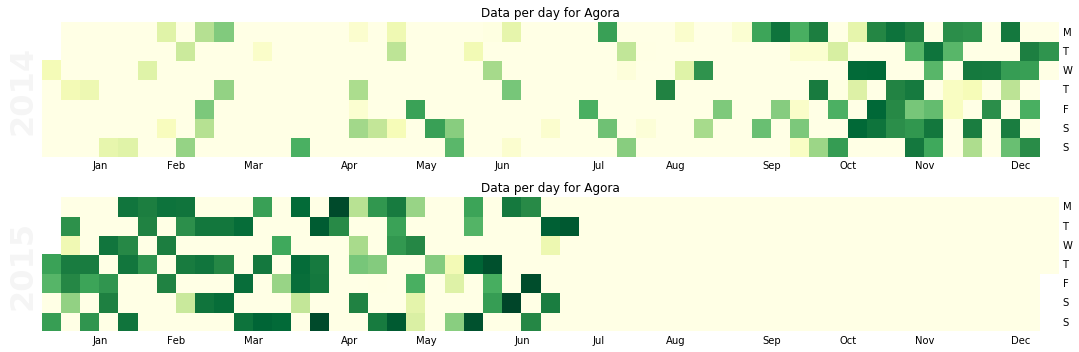

In [2]:
agora_df = pd.read_csv('data/agora_filesnum.out')
forum_df = pd.read_csv('data/agora-forum_filesnum.out')
all_days_df = generateFileCount(forum_df, agora_df)
events_ag = pd.Series(all_days_df['filenum_ag'])
events_for = pd.Series(all_days_df['filenum_for'])
calmap.calendarplot(events_ag, daylabels='MTWTFSS', cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0, fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora'});

>This calendars map show the amount of data per day we have for Agora and Agora Forum. We clearly have a satisfactory amount of data for the market, but we dont have a reliable amount for the forum. There is no stable web scrapping of both websites. In order to understand better this problem, we will study the uptime average of both services in the next part.

## 1.2) Services Uptime

> We then decide to use DNStats which is an up-to-date site tracking darknet markets, products, vendors, news, and more. This way, we can track the amount of available files for each days for Agora depending on the uptime of the sercices, or even see if the Onymous operation had an impact on the services uptime. 


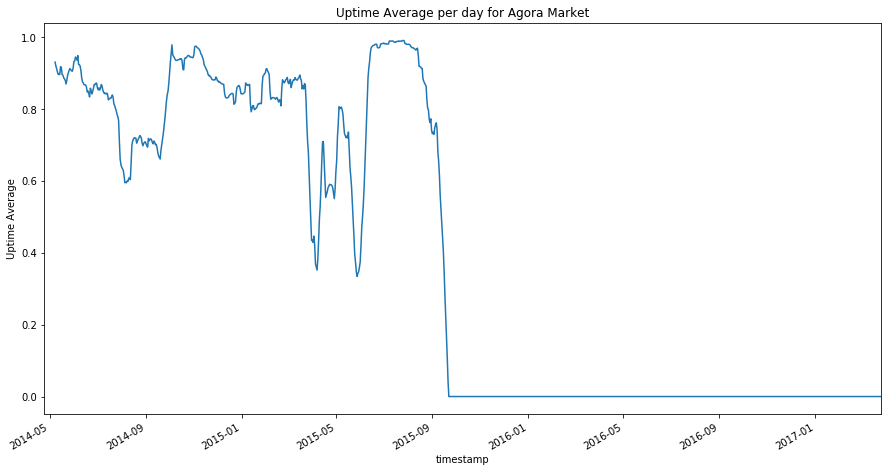

In [3]:
agora_df1 = pd.read_csv('data/agora_stats.out', sep=",")
agora_df1 = agora_df1.drop(columns=['rid', 'speed_download', 'total_time'])
agora_df1['timestamp'] = agora_df1['timestamp'].apply(pd.to_datetime)

agora_df1['siteup'] = agora_df1['httpcode'].apply(fixIsUp)
agora_df1['timestamp'] = agora_df1['timestamp'].apply(truncateTime)

agora_subdf1 = agora_df1[agora_df1['sitename'] == "Agora"]
agora_subdf1 = agora_subdf1.groupby(by='timestamp').mean()
    
plotUptime(agora_subdf1['siteup'], 'Uptime Average per day for Agora Market')

> We observe that the uptime average is very fluctuant over the time for both Agora and Agora Forum. It made the webscrapping quite difficult to do, we have to expect a lot of missing data. Now let's take a look just before and after the Onymous operation

## 1.3) Data Gathering and Parsing
### Gram archives
> Grams was a search engine for market listings on the Tor network. The archive provided by the dataset contains, for each day, a csv file per queried market (in our case, we used Agora, SilkRoad, Evolution and Cloud9). Every row corresponds to a single listing and contains, among others, its vendor, name, description, price, origin country and destination country - although most values are missing for this particular field. 

> Speaking for Agora's listing, these data are quite redundant and contain less information than what could be extracted from the Agora archive (described below). However, it could be used as a mean to cross-check the data extracted from the Agora archive and fill some mising values from there.

> Globally, these datasets were used in combination to determine the presence of Agora's vendors on other markets.

### Agora archives
> The Agora archive has the following tree structure:
```
data/
└── agora
      └── YYYY-MM-DD
          ├── index.html # main page of Agora
          │
          ├── css # css files for the websites
          │
          ├── fonts # fonts for the websites
          │
          ├── info # fixed pages that contains rules and informations
          │
          ├── cat # Directory containing list of listing for every category
          │   ├── cat_name_hash
          │   │   ├── page_0.html # Contains Title, Ships Fr. Ships To, Price in BTC, vendor_name
          │   ├── [...]
          │   │   ├── page_N.html
          ├── p # Directory containing list of all listings page
          │   ├── listing_0_hash.html
          │   ├── [...]
          │   └── listing_N_hash.html
          └── vendor # Directory containing list of all vendors profile page
              ├── vendor_0_name.html
              ├── [...]
              └── vendor_N_name.html
```
> In order to gather the needed data for our analysis, we decide to parse the following files for each date: 
   - All vendor pages, informations about suppliers, we selected and parsed the following features: 
   - All cat pages, information about available products on the market classed by category   
   
**Vendors**

|Features Name| Explanaition|
|:---|:---| 
|**name**|Name of the vendor|
|**rating**|Mean rating|
|**lastSeen**|Last time he connects to Agora, with respect to the date of parsing|
|**#products**|number of products available on the market|
|**#Deals**|Approximative number of deals|
|**parsingDate**|Date of the parsing|
|**country**|Country if mentioned|

**Products**

|Features Name| Explaination|
|:---|:---| 
|name|Description of the product|
|from|Origin of the product|
|to|Destination allowed by the vendor|
|vendor|Name of the vendor|
|cat|Category of the product|
|cat_hash|unique hash of the category|
|date|Date of the parsing|



## 1.4) Data Cleaning & Enrichment

In [4]:
vendorsDF = pd.read_csv('saved_gen_df/vendorsDF_lastSeen_country_df.csv').drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import nbProductsParse as t

In [29]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.option("header", "true").csv("data/cat_csv/*.csv")
df.count()

2805212

>So in total we have parsed 2805212 products (some of them are duplicates from one day to the other), we have the following features: 

In [7]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: string (nullable = true)
 |-- from: string (nullable = true)
 |-- to: string (nullable = true)
 |-- vendor: string (nullable = true)
 |-- cat_hash: string (nullable = true)
 |-- cat: string (nullable = true)
 |-- date: string (nullable = true)



> After some analysis, we cleaned the data as follow: 
 - Remove rows without a valid date, error during parsing, file not complete 
 - Remove rows without a price or not decimal, 642 in total, mainly due to error during parsing.
 - Remove the rows where name is null, all the columns are usually null in this case, (6 rows)
 - Lowercase and process the countries by replacing most common typos by real countries name
 - Process the hashs by removing badly parsed ones 
 - Merge categories that changed names between 2014 and 2015
 
> The cleaning methods are available in the file scripts/libs/milestone2Methods

In [8]:
df = cleanListings(df)

#### Consistency of data
> Once our data cleaned, we wanted to know if the number of listing per day parsed was consistent, it is possible that sometimes, since we have seen that the market was highly instable, the scrapping for a certain day was incomplete before the site went down, in this case we will not be able to use these datas 


##### Raw data

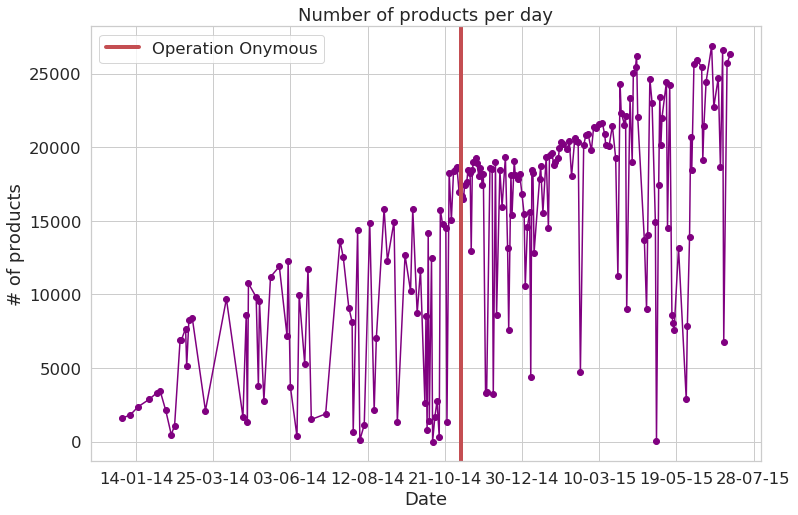

In [9]:
products_per_day = df.groupby("date").agg(count("date").alias("numberOfProductsParsed")).toPandas()
products_per_day = products_per_day[products_per_day['date'].str.contains("\d\d\d\d-\d\d-\d\d")]
products_per_day['date'] = pd.to_datetime(products_per_day['date'],infer_datetime_format=True) 
products_per_day = products_per_day.sort_values(by='date', ascending=True, na_position='first')

plotNDate(products_per_day['date'],products_per_day['numberOfProductsParsed'], 10,"Number of products per day", "# of products")


> We can see here that we have a lot of missing values, the number of products increase linearly but it drop a lot unpredictably, it seems to be due to the market instability, as explained previously.

#### Estimation

>In order to get the correct number of products per date, we parsed the main page of Agora, in which there is an approximation by category of the number of product, for example, if the category Drugs contains 1086 products one day, the website will inform 1000+ produtcs in that category. By adding the numbers given for each category we can approximate the number of products for each day and estimate if the products we effectively parsed are correct or not.

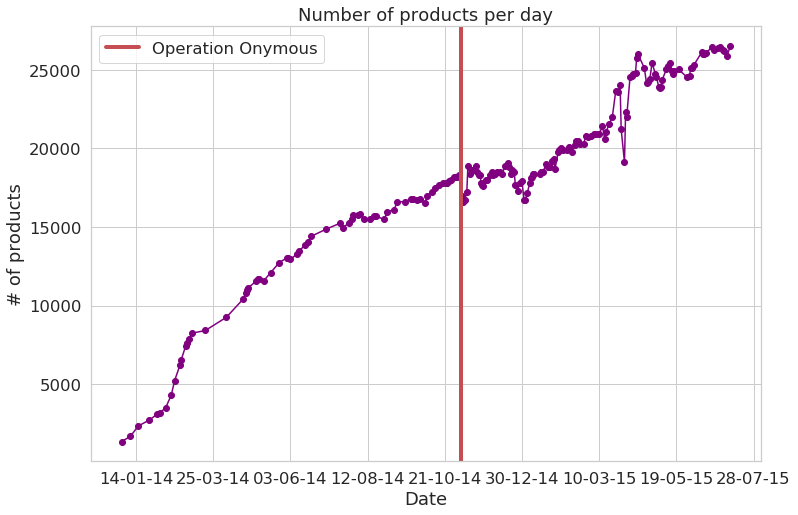

In [10]:
products_per_day_estimated = t.directoryToDF("data/index/")
products_per_day_estimated['date'] = pd.to_datetime(products_per_day_estimated['date'],infer_datetime_format=True) 
products_per_day_estimated = products_per_day_estimated.sort_values(by='date', ascending=True, na_position='first')
plotNDate(products_per_day_estimated['date'],products_per_day_estimated['numberOfProducts'], 10,"Number of products per day", "# of products")

> We can see here that if we pick the number of products obtained in the main page of agora, the result seems more predictable than before, it could be a solution to our missing data problem, we just need to compare this values to the ones previously obtained with our list of all products per year and keep only the date in which we have a satisfactory amount of data compare to the numbers shown on the agora main page. 
> Furthemore, we observe a decrease in the number of products just during the onymous operation

#### Filtering of badly scrapped days

> Now that we have our estimation of the actual numbers of products available on Agora Market, we can delete the days in which we have highly missing datas. In order to keep a fair amount of data points, we fixed the ratio between the estimate number of products and the parsed one to 90%.

In [11]:
# Join Estimated and Parsed products and add ratio
good_dates = pd.merge(left=products_per_day,right=products_per_day_estimated, left_on='date', right_on='date')
good_dates['ratio_parsed_estimated'] = (100*good_dates['numberOfProductsParsed']/good_dates['numberOfProducts'])

# Remove the dates that have a number of products too different
good_dates = good_dates[good_dates['ratio_parsed_estimated'] > 90]
good_dates['date'] = pd.to_datetime(good_dates['date'],infer_datetime_format=True) 

# Remove the dates that are too close to each other < 3 days
good_dates["diff"] = good_dates.date.diff().dt.days.fillna(0)
good_dates['diff'] = good_dates['diff'].rolling(window=2).sum()
good_dates = good_dates[good_dates['diff'] > 3]

good_dates.count()

date                      84
numberOfProductsParsed    84
numberOfProducts          84
ratio_parsed_estimated    84
diff                      84
dtype: int64

> After the filtering we keep 84 dates out of 201, luckily, most of the wrongly scrapped days are not during Onymous but eralier in 2014, if we plot again the actual number of products per days parsed with the filtered dates we get the following graph: 

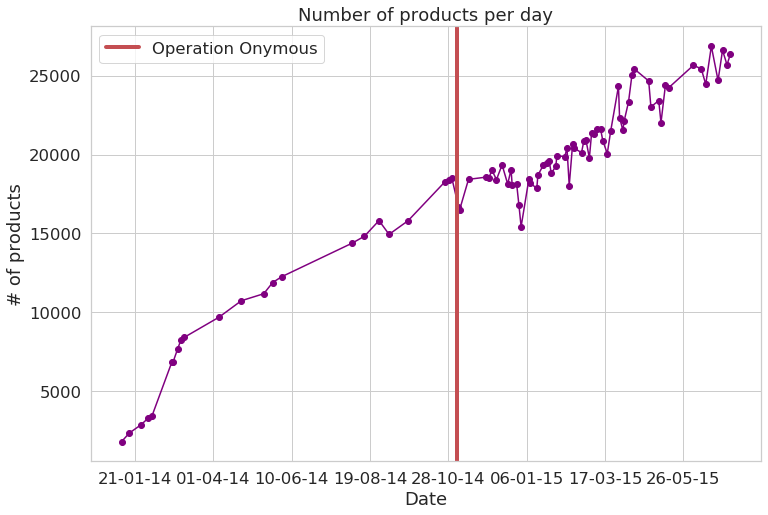

In [12]:
plotNDate(good_dates['date'],good_dates['numberOfProductsParsed'], 10,"Number of products per day", "# of products")

> Althought more than 3/4 of the data we parsed is highly incomplete, the graph above tells us that during the period of Onymous, the data is often complete, this quite helpful for us. We can observe here a gap in the number of products available on Agora just after Onymous, indeed, the operation had an impact on the market but it recovers quickly. Now that we can trust our data, let's filter our df containing all the products with this dates.

In [13]:
# Filter the products with the good dates
dates = good_dates['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
df = df.filter(col('date').isin(dates.tolist()))
df = df.withColumn("price", df["price"].cast(FloatType()))

## Market Analysis

>In this section, we will try to understand all the products listed in agora-market that we managed to retrieve.
Let's first get our dataframe containing all the parsed products from the scrapping made between 2014/01/01 to 2015/08/01.

### Active vendors

> Here we want to see if the total number of active vendors by day, was impacted by Onymous

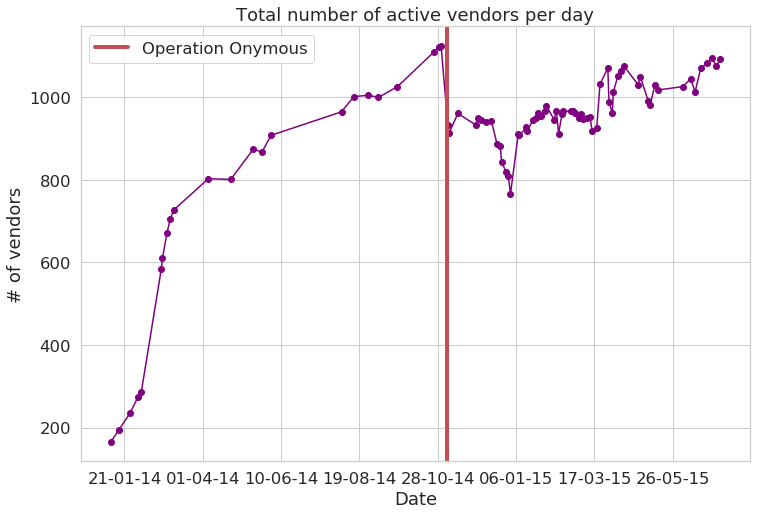

In [14]:
# Get the number of distinct vendors by date
vendors = df.groupby("date").agg(countDistinct('vendor').alias("numberOfVendor")).toPandas()
vendors['date'] = pd.to_datetime(vendors['date'],infer_datetime_format=True) 
vendors = vendors.sort_values(by='date', ascending=True, na_position='first')
vendors.set_index('date', inplace=True)

# Plot
plotNDate(vendors.index,vendors['numberOfVendor'], 10,"Total number of active vendors per day", "# of vendors")


>We can see here that 311 vendors was either removed or removed their products just during the operation Onymous and it seems to never recover before the site was definitevely shutdown in august 2015. Let's see if those missing vendors quit definitevely and if the upside trend is due to new vendors on the platform : 

In [16]:
others_columns = ['Chemicals', 'Drug paraphernalia','Electronics', 'Forgeries', 
                  'Jewelry', 'Other', 'Services', 'Tobacco', 'Weapons']

def processCat(cat):
    # Take only top category
    cleanr = cat.split("/")
    if cleanr[0] == "Info":
        return "Information"
    if cleanr[0] in others_columns:
        return "Others"
    return cleanr[0]

udf_func_Cat = udf(processCat, StringType())
all_together=df.withColumn("cat", udf_func_Cat(col("cat")))
all_together = all_together.groupby('date', 'vendor', 'cat').agg(mean('price').alias('price'), count('cat').alias("count")).toPandas()
vendorsDF['country'] = vendorsDF['country'].str.lower()
vendorsDF['country'] = vendorsDF['country'].apply(countryToContinent)
merged_all_together = pd.merge(left=all_together,right=vendorsDF[['name', 'parsingDate', '#Deals', 'country']], left_on=['vendor', 'date'], right_on=['name', 'parsingDate'], how="left")
merged_all_together = merged_all_together.drop(['name', 'parsingDate'], axis=1)

merged_all_together.to_csv("test.csv")


'\nudf_func_Cat = udf(processCat, StringType())\nall_together=df.withColumn("cat", udf_func_Cat(col("cat")))\nall_together = all_together.groupby(\'date\', \'vendor\', \'cat\').agg(mean(\'price\').alias(\'price\'), count(\'cat\').alias("count")).toPandas()\nvendorsDF[\'country\'] = vendorsDF[\'country\'].str.lower()\nvendorsDF[\'country\'] = vendorsDF[\'country\'].apply(countryToContinent)\nmerged_all_together = pd.merge(left=all_together,right=vendorsDF[[\'name\', \'parsingDate\', \'#Deals\', \'country\']], left_on=[\'vendor\', \'date\'], right_on=[\'name\', \'parsingDate\'], how="left")\nmerged_all_together = merged_all_together.drop([\'name\', \'parsingDate\'], axis=1)\n\nmerged_all_together.to_csv("test.csv")\n'

In [20]:
merged_all_together = pd.read_csv('saved_gen_df/vendorsDF_lastSeen_country_df.csv')

### Big vs Small suppliers

> In order to better understand why some of the vendors left when others stayed, we decide to analyse the number of products sold by each supplier

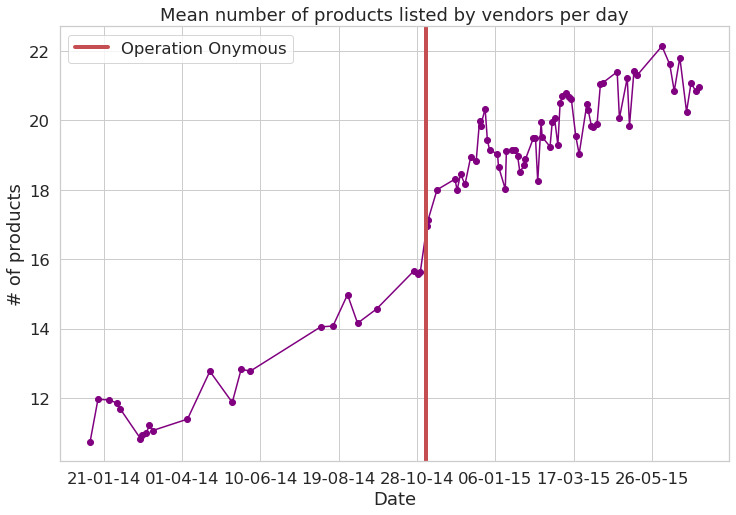

In [21]:
nbposts_per_vendors_date = df.groupby("date", "vendor").agg(countDistinct('name').alias("numberOfPosts")).toPandas()
nbposts_per_vendors_date['date'] = pd.to_datetime(nbposts_per_vendors_date['date'],infer_datetime_format=True) 
nbposts_per_vendors_date = nbposts_per_vendors_date.sort_values(by='date', ascending=True, na_position='first')
nbposts_per_vendors_date = nbposts_per_vendors_date.set_index('date')
nbposts_per_vendors_date.head()
plotNDate(nbposts_per_vendors_date.groupby("date").median().index,nbposts_per_vendors_date['numberOfPosts'].groupby("date").mean(), 10,"Mean number of products listed by vendors per day", "# of products")

>We can see here that the mean number of products listed by the active suppliers is increasing a lot just after Onymous, since the number of suppliers is decreasing at this period, it may means that those who left had lower mean number of products to sell than those who stayed, let's demonstrate this by plotting the mean number of products for each categories:

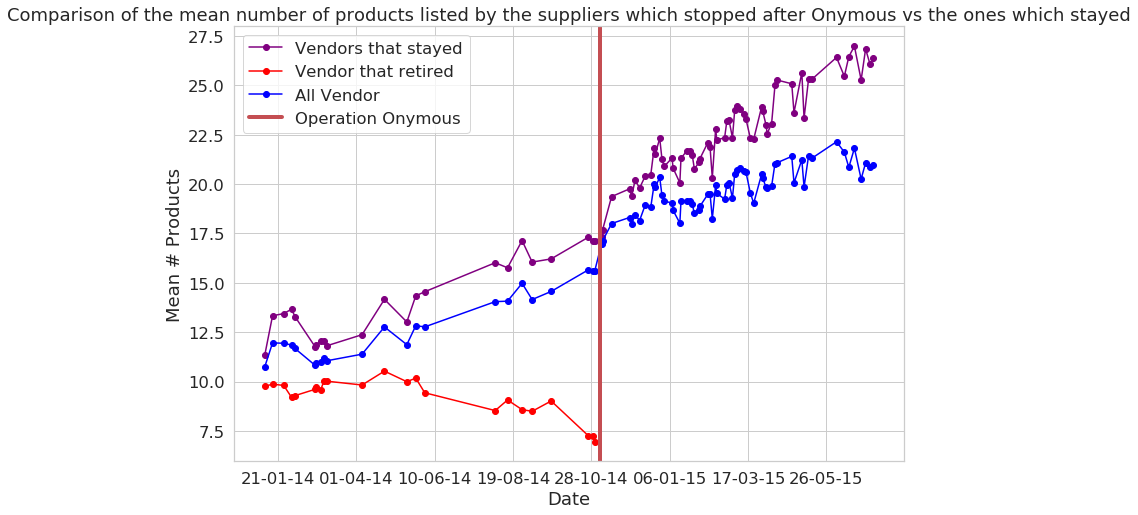

In [22]:
before = df.filter(df.date < "2014-11-05").select('vendor').distinct().toPandas()
after = df.filter(df.date > "2014-11-05").select('vendor').distinct().toPandas()

vendors_that_stayed = before[before['vendor'].isin(after['vendor'])]
vendors_that_retired = before[~before['vendor'].isin(after['vendor'])]
vendors_that_stayed = nbposts_per_vendors_date[nbposts_per_vendors_date['vendor'].isin(vendors_that_stayed.values.squeeze())].groupby('date').mean()
vendors_that_retired = nbposts_per_vendors_date[nbposts_per_vendors_date['vendor'].isin(vendors_that_retired.values.squeeze())].groupby('date').mean()
all_vendors = nbposts_per_vendors_date.groupby('date').mean()
plot3Date(vendors_that_stayed, vendors_that_retired,all_vendors )

> The above chart confirm our hypothesis, indeed the mean number of products available each day by the vendors is higher for those who stayed after Onymous than those who stopped. Moreover, the "big" sellers seems to grow faster than the all the active vendors after Onymous.

### New vendors
> While the Onymous operation has had a significant negative impact on the total number of suppliers in the Agora market, it has also closed other large markets, such as Silkroad, so we can ask ourselves if the closing of these markets entails moving users to Agora. 

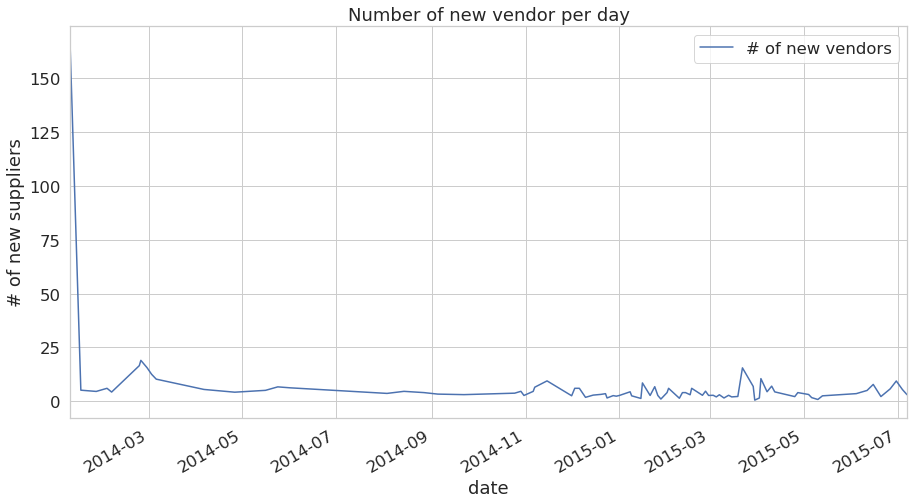

In [23]:
new_vendors = pd.DataFrame()
new_vendors['count'] = nbposts_per_vendors_date[~nbposts_per_vendors_date.duplicated(subset="vendor", keep='first')]['vendor'].groupby('date').count()

new_vendors.reset_index(level=0, inplace=True)
new_vendors['difference'] = new_vendors['date'].diff().fillna(0)
new_vendors['# of new vendors'] = new_vendors['count']/(new_vendors['difference'].dt.days + 1)
new_vendors = new_vendors[['date', '# of new vendors']]
new_vendors.set_index('date', inplace=True)

fig, ax1 = plt.subplots( figsize=(15,8))
ax1.set_ylabel('# of new suppliers')
new_vendors.rolling(window=1).mean().plot(
      kind='line', use_index=True, ax=ax1)
ax1.tick_params(axis='y')
plt.title("Number of new vendor per day")
plt.show()



>We can see here that this is not the case, the number of new suppliers who publish a product each day is relatively stable, about 5 per day. A vendor is considered new the day when he publish is first product.

### Displaced Vendors

> We saw that the Onymous operation had a significant impact on the suppliers of Agora Market, a lot of small vendors retired after this operation. In another hand, the operation didn't seem to impact the big suppliers of Agora. We assume that these conclusion are true for other market such as Silkroad, the small suppliers left after it was close and the big suppliers continue their deals on other platforms. But if this is the case, how can we explain that we don't see any upward trend in the number of new suppliers after the operation on Agora ? We made the assumption that it was because most of the big suppliers had already an account on several market. We compared the username of the suppliers present on Agora and Silkroad, BLAVLA and VLAVLA before Onymous.
In order to compare usernames, since some times sellers use slightly different name (Uppercase letters, number instead of letters, etc..) we also compared them with an hamming distance equal or inferior to 1 and lowercased all usernames

In [31]:
vendor_shops_df = pd.read_csv('saved_gen_df/vendor_markets.csv')

In [45]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
agora_surv_df = vendor_shops_df[(vendor_shops_df['date_max'] > '2015-01-01') &
                           (vendor_shops_df['date_min'] < '2014-11-06')]
test = agora_surv_df.sum()
colors = ['mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=['A & Dead', 'A Only', 'A & Evo'],
                             values=[test['ag_and_dead_market'], test['h_ag_only'], test['ag_and_evo_market']])],
               layout=go.Layout(title='Market Presence of Vendors Still Active after Onymous'))
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()


> Clearly, vendors that also had a shop on other markets seem to have better sustained the consequences of operation Onymous, consisting around 63% of the remaining population.

In [46]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
agora_surv_df = vendor_shops_df[(vendor_shops_df['date_max'] < '2014-12-01')]
test = agora_surv_df.sum()
colors = ['mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=['A & Dead', 'A Only', 'A & Evo'],
                             values=[test['ag_and_dead_market'], test['h_ag_only'], test['ag_and_evo_market']])],
               layout=go.Layout(title='Market Presence of Vendors Inactive after Onymous'))
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

# Data to 1

> Combined to the insight provided by the previous chart, we can clearly see a tendency for vendors who have stopped their activity to be most likely to only have setup shop on Agora. Respectively, that vendors who remained active after Onymous were more likely to have several shops setup.

> One could infer that vendors who have shops on several markets are more likely to be a bigger operation and thus, less sensitive to an abrupt activity on stop on any platform they may be active on. Either way, it seems obvious that the overall vendor activity remained intact on the long term.

## Product Analysis

### Type of products

> First of all, we wanted to know if the type of products was impacted by the operation onymous, you can find below a stacked chart of the number of products in each categories available on Agora

In [30]:

categories = df.select("date", "cat").groupby('date', 'cat').count().toPandas()
categories['date'] = pd.to_datetime(categories['date'],infer_datetime_format=True) 
categories_count = categories.sort_values(by='date', ascending=True, na_position='first')
categories_count = pd.pivot_table(categories_count, values='count', index='date',
                     columns=['cat'])
categories_count = categories_count.fillna(0)
categories_count.plot.area(figsize=(15,10))

ValueError: ('Unknown string format:', 'nL0oges5ZX')

In [ ]:
categories_count.columns

> We can see here that there is no significatif impact on the proportion of each categories

### Products Price 

> We now take a look at the prices evolution on the Agora marketplace. To achieve that we look at the average price of all products at each parsing date. We hope to find a noticable change arround the date of Operation Onymous

In [27]:
date = merged_inner['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
date = date[:22]
date

NameError: name 'merged_inner' is not defined

In [28]:

# Call method to preprocess data using spark (groupby and aggregate)
dfAvgBTCprice = sparkProdPricesPrep(priceDf)

# Export Agregated data to pandas
pdAvgPriceDF = dfAvgBTCprice.toPandas()

# Load dataframe for Bitcoin value
btcPriceDF= pd.read_csv("data/bitcoin_csv.csv",usecols=['date', 'price(USD)'])
btcPriceDF = preprocessBTCprices(btcPriceDF)
# Apply conversion
pdAvgPriceDF = convertBTCprices(pdAvgPriceDF,btcPriceDF)
pdAvgPriceDF = pdAvgPriceDF.set_index('date')

# Simply remove extreme outliers
pdAvgPriceDF = pdAvgPriceDF[pdAvgPriceDF['avgPrice(dollars)'] < 25000]
pdAvgPriceDF = pdAvgPriceDF.sort_index()
dateSerie = pdAvgPriceDF.index.to_series()
dateSerie = dateSerie.reset_index(drop=True)

# Clean data
compressionWidth = 20
correctedDF= pdAvgPriceDF.copy()
correctedDF.iloc[compressionWidth:-compressionWidth] = correctedDF.iloc[compressionWidth:-compressionWidth].apply(lambda x: correctOutliers(x,compressionWidth,dateSerie,pdAvgPriceDF), axis=1)
rolledDF = correctedDF.copy()
rolledDF = rolledDF.rolling(10).mean()

# Chose data to plot
plottedDataFrame = rolledDF

PlotPrice2LinesAndDots(plottedDataFrame.index,plottedDataFrame['avgPrice(dollars)'],pdAvgPriceDF['nbOfProducts'], 15 ,'Average products price along time','avgProductsPrice($)','Size of the parsed listing',btcPriceDF)

NameError: name 'priceDf' is not defined

> BLABLABLA

In [ ]:
## Import/Export Analysis

In the further analysis we will focus on the importation/exportation toward several continents: 

In [ ]:

# Select the range dates
date = good_dates['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
#date = date[23:]
date.shape

confusion_matrix = generateSquaredFluxMatrix(df, date)

# Plot
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(confusion_matrix, annot = True, ax=ax)

In [ ]:
> In the graph above you can see BLABLABLA

> In order to better vizualise the the numbers of products that cross borders we BLABLBLA

In [ ]:
udf_func_C = udf(countryToContinent, StringType())
udf_func_Cat = udf(processCat, StringType())

# Remove datas products, there isn't a real delivery for those, only via internet
from_to_continents = df.withColumn("cat", udf_func_Cat(col("cat"))).filter(~col('cat').isin("Information", "Data", "Other", "Services"))
from_to_continents = from_to_continents.select('date', pyspark.sql.functions.explode(col("to")).alias("to"), "from")
from_to_continents = from_to_continents.select('date', pyspark.sql.functions.explode(col("from")).alias("from"), "to")
from_to_continents = from_to_continents.filter(col('date').isin(date.tolist()))
from_to_continents = from_to_continents.withColumn("from", udf_func_C(col("from")))
from_to_continents = from_to_continents.withColumn("to", udf_func_C(col("to")))
from_to_continents = from_to_continents.filter(~col('from').isin("None")).filter(~col('to').isin("None"))

from_to_by_date = from_to_continents.groupby("date", "from", "to").count()
intra_ratio = from_to_by_date[from_to_by_date["from"] == from_to_by_date["to"]].groupby("date").agg(sum("count").alias("intra_ratio"))
extra_ratio = from_to_by_date[from_to_by_date["from"] != from_to_by_date["to"]][from_to_by_date["to"] != "worldwide"].groupby("date").agg(sum("count").alias("extra_ratio"))
ww_ratio = from_to_by_date[from_to_by_date["to"] == "worldwide"].groupby("date").agg(sum("count").alias("ww_ratio"))
intra_extra_ratios = intra_ratio.join(extra_ratio, on=['date'], how='inner')
intra_extra_ratios = intra_extra_ratios.join(ww_ratio, on=['date'], how='inner')

intra_extra_ratios_pd = intra_extra_ratios.toPandas()
intra_extra_ratios_pd['date'] = pd.to_datetime(intra_extra_ratios_pd['date'],infer_datetime_format=True) 
intra_extra_ratios_pd = intra_extra_ratios_pd.set_index('date')

intra_extra_ratios_pd = intra_extra_ratios_pd.sort_values(by='date', ascending=True, na_position='first')



intra_extra_ratios_pd.plot.bar(stacked=True, figsize=(15,10))

> The number of products having an destination mentionned seems badly impacted by Onymous, BLABLABLA but the ratio between continent to continent and continent to other continent is quite stable .
Let's see in details the number of product sends to each continent by date

In [ ]:
products_to = from_to_by_date.toPandas().groupby(['date', 'to']).sum()
#test.pivot(columns =test.index.get_level_values(1), values= "count", index=test.index.get_level_values(0))
products_to = products_to.reset_index()
products_to['date'] = pd.to_datetime(products_to['date'],infer_datetime_format=True) 
products_to = products_to.sort_values(by='date', ascending=True, na_position='first')
products_to = products_to.set_index('date').pivot(columns="to").fillna(0)
products_to.columns = products_to.columns.droplevel()
products_to.plot(figsize=(15, 10))

> We can see BLABLABLA, but what about the origin country ? 

In [ ]:
products_from = from_to_by_date.toPandas().groupby(['date', 'from']).sum()
#test.pivot(columns =test.index.get_level_values(1), values= "count", index=test.index.get_level_values(0))
products_from = products_from.reset_index()
products_from['date'] = pd.to_datetime(products_from['date'],infer_datetime_format=True) 
products_from = products_from.sort_values(by='date', ascending=True, na_position='first')
products_from = products_from.set_index('date').pivot(columns="from").fillna(0)
products_from.columns = products_from.columns.droplevel()

products_from.plot(figsize=(15, 10))

> BLABLABLABLA 

In [ ]:
## Putting Everything together

> In order to have a final vizualisation of the different features we studied here, we needed to cross our df to have all the informations at the same place, BLABLABLA

In [ ]:
others_columns = ['Chemicals', 'Drug paraphernalia','Electronics', 'Forgeries', 
                  'Jewelry', 'Other', 'Services', 'Tobacco', 'Weapons']

def processCat_1(cat):
    # Take only top category
    cleanr = cat.split("/")
    if cleanr[0] == "Info":
        return "Information"
    if cleanr[0] in others_columns:
        return "Others"
    return cleanr[0]

def median(values_list):
    med = np.median(values_list)
    return float(med)

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend()
plt.show()
#plotNDate(from_to_not_usa.index,from_to_not_usa.name, 10,"Total number of active vendors per day", "# of vendors")

In [ ]:
from_usa = test[test['from'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])]
from_to_usa = from_usa[from_usa['to'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])].groupby('date').count()
from_to_not_usa = from_usa[~from_usa['to'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])].groupby('date').count()

udf_func_Cat = udf(processCat_1, StringType())
all_together=df.withColumn("cat", udf_func_Cat(col("cat")))

all_together = all_together.groupby('date', 'vendor', 'cat').agg(udf_median(collect_list(col('price'))).alias('mean_price_btc'), count('cat').alias("count")).toPandas()
#all_together = all_together.groupby('date', 'vendor', 'cat').agg(mean("price").alias('mean_price_btc'), count('cat').alias("count")).toPandas()
all_together['date'] =  pd.to_datetime(all_together['date'],infer_datetime_format=True) 

vendorsDF['country'] = vendorsDF['country'].str.lower()
vendorsDF['country'] = vendorsDF['country'].apply(countryToContinent)
vendorsDF['parsingDate'] = pd.to_datetime(vendorsDF['parsingDate'],infer_datetime_format=True) 

merged_all_together = pd.merge(left=all_together,right=vendorsDF[['name', 'parsingDate', '#Deals', 'country']], left_on=['vendor', 'date'], right_on=['name', 'parsingDate'], how="left")
merged_all_together = merged_all_together.drop(['name', 'parsingDate'], axis=1)

# Remove unamed vendors
merged_all_together = merged_all_together[~merged_all_together['vendor'].isnull()]
merged_all_together = merged_all_together.sort_values(['vendor', 'date'], ascending=[True, True])
merged_all_together = merged_all_together.set_index('date')

# Add btc and usd prices
merged_all_together = pd.concat([merged_all_together, btcPriceDF], axis=1, join='inner', ignore_index=False, verify_integrity=False, copy=True)
merged_all_together['mean_price_usd'] = merged_all_together['mean_price_btc'] * merged_all_together['price']


# Fill others na values by propagation of the last valid observation forward to next valid 
merged_all_together = merged_all_together.fillna(method='bfill')

# Drop nas that couldn't be fill because only one vendor of that name, not revelant, only one product
merged_all_together = merged_all_together[~merged_all_together['#Deals'].isnull().values]
merged_all_together = merged_all_together[~merged_all_together['vendor'].str.contains("<")]

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend()
plt.show()
#plotNDate(from_to_not_usa.index,from_to_not_usa.name, 10,"Total number of active vendors per day", "# of vendors")

In [ ]:
from_usa = test[test['from'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])]
from_usa[from_usa['to'] == 'worldwide'].count()
# Save to csv for visualization
merged_all_together.to_csv("test.csv")

In [ ]:
date = merged_inner['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
countries = ['europe','bulgaria', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
countries_to = ['worldwide','europe','usa', 'bulgaria', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
test = df.select('date', 'name', 'cat', "from", pyspark.sql.functions.explode(col("to")).alias("to")).filter(~col('to').isin("None"))
test = test.select('date', 'name', 'cat', "to", pyspark.sql.functions.explode(col("from")).alias("from")).filter(~col('from').isin("None"))
test = test.filter(col('date').isin(date.tolist()))
test = test.filter(col('from').isin(countries))
test.count()

In [ ]:
# usa -> usa : 88928
# usa ->x usa : 38593
# europe ->x europe: 121144
# europe -> europe: 33000

import pyspark
after_top = after.select(pyspark.sql.functions.explode(col("to")).alias("to")).groupby("to").agg(count("to")).toPandas()
after_top = after_top.sort_values(by='count(to)', ascending=False, na_position='first')
after_top = after_top.set_index("to")
#plot = after_top.nlargest(20, "count(to)").plot.pie(y='count(to)', figsize=(15, 15))


In [ ]:
before_top = before.select(pyspark.sql.functions.explode(col("to")).alias("to")).groupby("to").agg(count("to")).toPandas()
before_top = before_top.sort_values(by='count(to)', ascending=False, na_position='first')
before_top = before_top.set_index("to")
#plot = before_top.nlargest(20, "count(to)").plot.pie(y='count(to)', figsize=(15, 15))

In [ ]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(16,13))
top20 = after_top.nlargest(10, "count(to)")
values = top20['count(to)'].values
labels = top20.index
explode = np.zeros(len(values))
plt.pie(values, labels=labels,
explode=explode, autopct='%1.1f%%',
counterclock=False, shadow=False)
plt.title('After onymous to countries')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(16,13))
top20 = before_top.nlargest(10, "count(to)")
values = top20['count(to)'].values
labels = top20.index
explode = np.zeros(len(values))
plt.pie(values, labels=labels,
explode=explode, autopct='%1.1f%%',
counterclock=False, shadow=False)
plt.title('Before onymous to countries')
plt.show()

In [ ]:
before = before.groupby("from").agg(count("from").alias("before_count"))
after = after.groupby("from").agg(count("from").alias("after_count"))
before.join(after, after['from'] == before['from'], "inner").show()

In [ ]:
join = before.join(after, after.col == before.col, "inner")
join.withColumn("Sub", col("before_count")-col("after_count")).show(300)

In [ ]:
> BLABLABLA

# 4) Conclusion

##  4.1) Research questions

Due to the large amount of time needed to process the data and handle missing data, we will restrict a bit our research questions : 

* How did it affect the global sales on a short and a longer timescale ?
* How was the user traffic affected ?
* How was the "online traffic" popularity affected ?
* Were there any trends in the forums during this kind of intervention ?
* How did the prices evolve globally ?




## 4.2) Potential issues

The main issues of this project are caused by the missing data, it is very complicated to give meaningful information when we cannot be certain that we cover all the services.

## 4.3) Going Further

